# ESCI 445 - Barotropic QG Model

This program solves the barotropic QG vorticity equation with flat terrain.

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

### <font color = 'blue'><i>*Define function for calculating the vorticity

In [2]:
def vorticity(stream, dd):
    '''Calculates vorticity on interior grid points, using the 5-pt Laplacian
    stencil.  Input is a 2D array of streamfunction, stream, and a floating-point value
    for the grid spacing, dd.
    Output is a 2D array of vorticity, with boundaries set to zero.'''
    
    nx, ny = np.shape(stream)  # Determines number of x and y grid points.
    zeta = np.zeros_like(stream)  # Creates vorticity array initialized to zero
    
    # Using implied loop
    zeta[1:nx-1,1:ny-1] = (stream[2:nx,1:ny-1]+stream[0:nx-2,1:ny-1] + \
                       stream[1:nx-1,2:ny]+stream[1:nx-1,0:ny-2] - \
                       4.0*stream[1:nx-1,1:ny-1])/dd**2
    
    return zeta

### <font color = 'blue'><i>*Define function for calculating the Jacobian (negative of vorticity advection)

The function should accept three arguments:

+ The 2D array of streamfunction values
+ The 2D array of vorticity values
+ The grid spacing

The function should return a 2D array of $J(\psi, \zeta)$ with all values on the boundaries and adjacent to the boundaries set to zero.

In [3]:
# Input should be streamfunction, vorticity, and grid spacing
def Jacobian(stream, vort, dd):
    '''Calculates Jacobian on interior grid points, using the 5-pt Laplacian
    stencil.  Input is a 2D array of streamfunction, vorticity, and a floating-point value
    for the grid spacing, dd.
    Output is a 2D array of Jacobian, with boundaries set to zero.'''
    
    nx, ny = np.shape(stream)  # Determines number of x and y grid points.
    
    J1 = np.zeros_like(stream)
    J2 = np.zeros_like(stream)
    J3 = np.zeros_like(stream)
    
    J1[2:nx-2,2:ny-2] = (1 / (4 * d**2)) * ((psi[3:nx-1,2:ny-2]-psi[1:nx-3,2:ny-2])*(vort[2:nx-2,3:ny-1]-\
                                            vort[2:nx-2,1:ny-3]) - (psi[2:nx-2,3:ny-1]-psi[2:nx-2,1:ny-3])* \
                                            (vort[3:nx-1,2:ny-2]-vort[1:nx-3,2:ny-2]))
        
    J2[2:nx-2,2:ny-2] = (1 / (4 * d**2)) * (psi[3:nx-1,2:ny-2]*(vort[3:nx-1,3:ny-1]-vort[3:nx-1,1:ny-3]) - \
                                      psi[1:nx-3,2:ny-2]*(vort[1:nx-3,3:ny-1]-vort[1:nx-3,1:ny-3]) - \
                                      psi[2:nx-2,3:ny-1]*(vort[3:nx-1,3:ny-1]-vort[1:nx-3,3:ny-1]) + \
                                      psi[2:nx-2,1:ny-3]*(vort[3:nx-1,1:ny-3]-vort[1:nx-3,1:ny-3]))
        
    J3[2:nx-2,2:ny-2] = (1 / (4 * d**2)) * (vort[2:nx-2,3:ny-1]*(psi[3:nx-1,3:ny-1]-psi[1:nx-3,3:ny-1]) - \
                                      vort[2:nx-2,1:ny-3]*(psi[3:nx-1,1:ny-3]-psi[1:nx-3,1:ny-3]) - \
                                      vort[3:nx-1,2:ny-2]*(psi[3:nx-1,3:ny-1]-psi[3:nx-1,1:ny-3]) + \
                                      vort[1:nx-3,2:ny-2]*(psi[1:nx-3,3:ny-1]-psi[1:nx-3,1:ny-3]))
    
    return (J1 + J2 + J3) / 3

### <font color = 'blue'><i>*Define function for calculating v-component of geostrophic wind

The function should accept two arguments:

+ The 2D array of streamfunction values
+ The grid spacing

The function should return the 2D array of $v_g$ with all values on the boundaries and adjacent to the boundaries set to zero.

In [4]:
# Input should be streamfunction and grid spacing
def v_geo(stream, dd):
    '''Calculates v component of the geostrophic wind on interior grid points. 
    Input is a 2D array of streamfunction and a floating-point value
    for the grid spacing, dd.
    Output is a 2D array of geostropic wind, with boundaries set to zero.'''
    
    nx, ny = np.shape(stream)
    vgeo = np.zeros_like(stream)
    
    vgeo[2:nx-2,2:ny-2] = (stream[3:nx-1,2:ny-2] - stream[1:nx-3,2:ny-2]) / (2*dd)
    
    return vgeo

### <font color = 'blue'><i>*Define function to perform relaxation

The function should accept four arguments:

+ The 2D array of vorticity values
+ The 2D array of the initial guess field for the streamfunction
+ The grid spacing
+ The relaxation tolerance

The function should return the 2D array of the streamfunction.

In [5]:
def relax(G, vort, d, epsilon):
    
    nx, ny = np.shape(vort)  #  Calculate shape of arrays
    R = np.zeros_like(vort)  # Array for residuals
    
    # Ensures one residual out of tolerance so that while loop will execute
    R[int(nx/2), int(ny/2)] = 9999.9

    # Calculate over-relaxation coefficient
    t = np.cos(np.pi/nx) + np.cos(np.pi/ny)
    alpha = (8 - 4 * np.sqrt(4-t**2)) / t**2

    # Loop for relaxation
    while (np.max(np.abs(R))) >= epsilon:
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                R[i,j] = (G[i-1,j] + G[i+1,j] + G[i,j-1] + G[i,j+1] - 4*G[i,j]) / d**2 - vort[i,j]
                G[i,j] = G[i,j] + alpha*(d**2/4) * R[i,j]
    
    # Remember to return your result!
    return G

### Read in initial streamfunction

In [6]:
file_in = 'barotropic_streamfunction_input.dat'
psi = np.transpose(np.loadtxt(file_in))  # transpose to get orientation correct

### Set up output file

In [7]:
# Set up and open output file
out_stream = 'barotropic-output.npy'  #  For numpy file output
outlist = []   # list for output arrays
outlist.append(np.copy(psi))    # Adds initial streamfunction to outlist for later saving to .npy file

### Set up some model parameters

In [8]:
shape = np.shape(psi)  # determine shape of data array
nx = shape[0]   # number of x grid points
ny = shape[1]   # number of y grid points
d = 2e5         # grid spacing in meters
dt = 15.0*60    # time step in seconds
beta = 1e-11    # beta in s^-1 m^-1
epsilon = 1e-8  # relaxation threshold (s^-1)
n_levels = 288   # final time level (or total number of iterations)
n_out = 24      # number of time steps between output

### Set up arrays for the vorticity values at the past, current, and next time steps

In [9]:
# Arrays for future, current, and past vorticity
vort_next = np.zeros(shape=(nx,ny), dtype = np.float64)
vort_now = np.zeros_like(vort_next)
vort_past = np.zeros_like(vort_next)

### <font color = 'blue'><i>*Calculate initial vorticity on all interior grid points.

In [10]:
#call vort function
#return into vort_now
vort_now = vorticity(psi, d)

### <font color = 'blue'><i>*Forward scheme for first time step

In [11]:
#swap vars
#call relax 
vort_next = vort_now - dt * (Jacobian(psi,vort_now,d) * beta  * v_geo(psi,d))

vort_past = np.copy(vort_now)
vort_now = np.copy(vort_next)

psi = relax(psi, vort_now,d, epsilon )

# Print status
s = '{0:d} of {1:d} steps complete.'
print(s.format(1,n_levels))

1 of 288 steps complete.


### <font color = 'blue'><i>*Time loop using leapfrog scheme

In [12]:
# Start time loop here (from 1 to n levels)

#loop (see textbook fig 7.2)
for n in range(1, n_levels): # start of time loop
   
    vort_next = vort_past - 2 *dt*(Jacobian(psi,vort_now,d)+beta*v_geo(psi,d))

    #Swap the vars
    vort_past = np.copy(vort_now)
    vort_now = np.copy(vort_next)
    
    psi = relax(psi, vort_now,d, epsilon )


    # The code below should be inside the time loop
    # Write output if timing right
    if (n+1) % n_out == 0:
        outlist.append(np.copy(psi))    # Adds psi to outlist

    # Print status
    print(s.format(n+1,n_levels))

2 of 288 steps complete.
3 of 288 steps complete.
4 of 288 steps complete.
5 of 288 steps complete.
6 of 288 steps complete.
7 of 288 steps complete.
8 of 288 steps complete.
9 of 288 steps complete.
10 of 288 steps complete.
11 of 288 steps complete.
12 of 288 steps complete.
13 of 288 steps complete.
14 of 288 steps complete.
15 of 288 steps complete.
16 of 288 steps complete.
17 of 288 steps complete.
18 of 288 steps complete.
19 of 288 steps complete.
20 of 288 steps complete.
21 of 288 steps complete.
22 of 288 steps complete.
23 of 288 steps complete.
24 of 288 steps complete.
25 of 288 steps complete.
26 of 288 steps complete.
27 of 288 steps complete.
28 of 288 steps complete.
29 of 288 steps complete.
30 of 288 steps complete.
31 of 288 steps complete.
32 of 288 steps complete.
33 of 288 steps complete.
34 of 288 steps complete.
35 of 288 steps complete.
36 of 288 steps complete.
37 of 288 steps complete.
38 of 288 steps complete.
39 of 288 steps complete.
40 of 288 steps comp

### Save data file

In [13]:
out_stream = 'barotropic-output.npy'
np.save(out_stream, outlist)

### Create plots

<IPython.core.display.Javascript object>


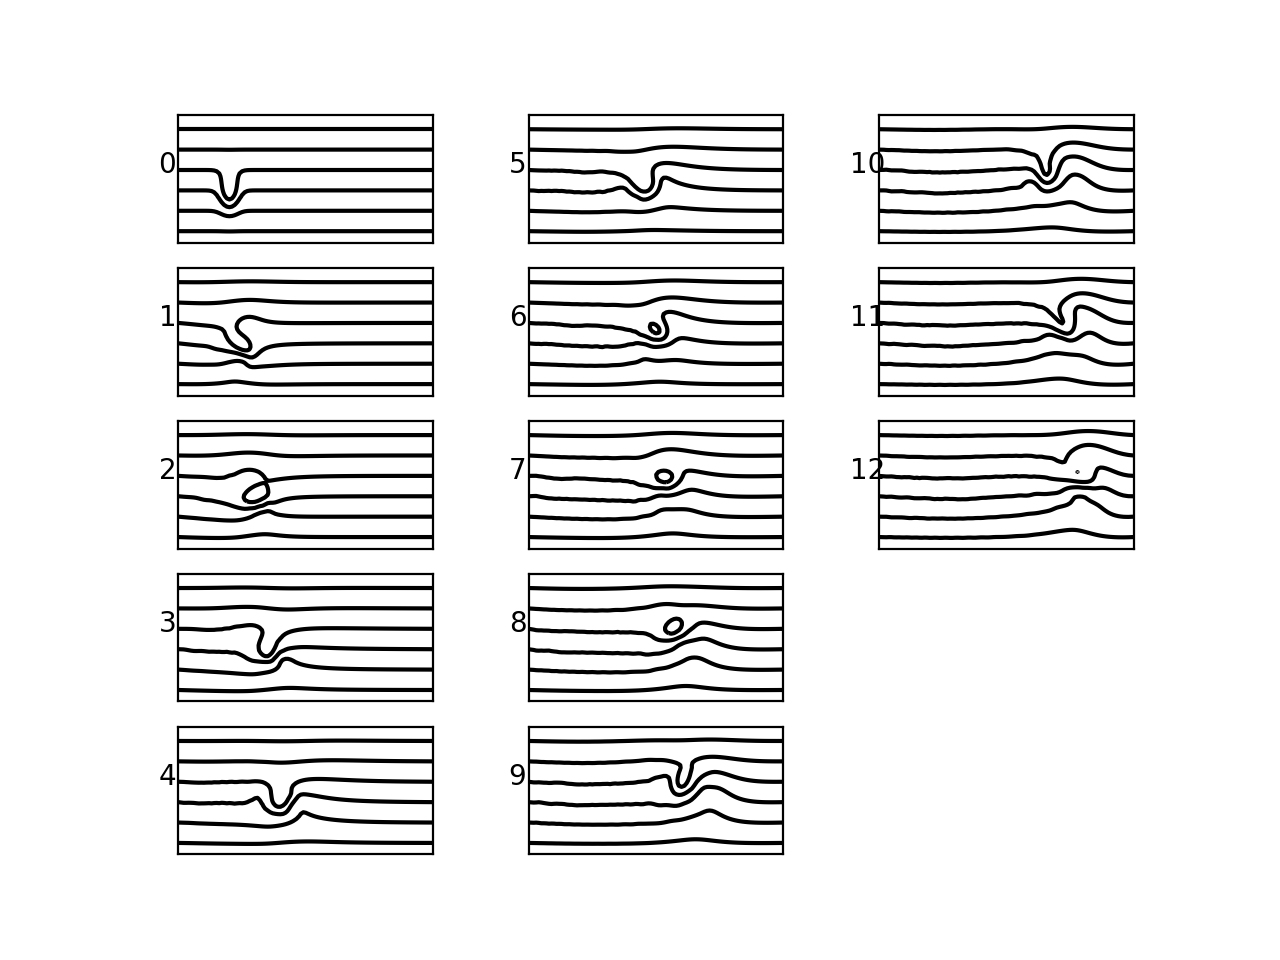

In [14]:
%matplotlib notebook

fig, ax = plt.subplots(int((len(outlist)+2)/3), 3) # three columns
axflat = np.transpose(ax).flatten()

for i, p in enumerate(outlist):
    axflat[i].contour(np.transpose(p), colors = 'black')
    axflat[i].set_ylabel(str(i), rotation = 'horizontal')

for i, a in enumerate(axflat):
    if i < len(outlist):
        a.set_xticks([])
        a.set_yticks([])
        a.set_aspect('equal')
    else:
        a.axis('off')  # turns off axes without data